## 1. Import the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## 2. Read The Training Data

In [2]:
file_path = r"C:\Users\admin\OneDrive\Desktop\Flights_SageMaker_Project\Data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-06,Delhi,Cochin,14:20:00,22:30,490,1.0,No Info,6938
1,Multiple Carriers,2019-06-15,Delhi,Cochin,11:30:00,19:15,465,1.0,No Info,16108
2,Jet Airways,2019-05-12,Kolkata,Banglore,17:00:00,22:05,1745,1.0,No Info,13067
3,Air India,2019-05-09,Delhi,Cochin,14:25:00,19:15,1730,2.0,No Info,13591
4,Air India,2019-03-06,Mumbai,Hyderabad,12:45:00,19:25,1840,2.0,No Info,13253
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-05-18,Delhi,Cochin,10:20:00,19:00,520,1.0,No Info,9794
636,Jet Airways,2019-05-21,Delhi,Cochin,08:00:00,04:25,1225,1.0,In-flight meal not included,12898
637,Jet Airways,2019-05-24,Kolkata,Banglore,09:35:00,09:45,1450,1.0,No Info,13067
638,Indigo,2019-06-12,Banglore,Delhi,07:10:00,10:05,175,0.0,No Info,4823


In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
    
    col: pd.to_datetime(train.loc[:,col], format ="mixed")
    for col in ['date_of_journey','dep_time','arrival_time']
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

## 3.High Level Sumamry of Data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [6]:
train.describe(include=[int,float])

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,638.132812,0.800000,8742.960938
std,512.107850,0.699206,4153.599984
min,80.000000,0.000000,1965.000000
25%,170.000000,0.000000,5041.500000
50%,497.500000,1.000000,8021.000000
75%,965.000000,1.000000,11982.000000
max,2565.000000,4.000000,27430.000000


>- Average flights duration is 638 min --> 10 hrs
>- Duratio has most highest value as of 2565 minutes means it has very large range.

In [7]:
train.describe(include='O')

,airline,source,destination,additional_info
count,640,640,640,640
unique,8,5,6,4
top,Jet Airways,Delhi,Cochin,No Info
freq,206,262,262,500


In [8]:
(
    train
    .assign(
        total_stops=train['total_stops'].astype(object)
    )
    .describe(include='O')
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,5.0,4
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,206,262,262,322.0,500


In [9]:
!pip install statsmodels

In [10]:
import eda_helper_functions

## 4. High Level Analysis of Missing Values

In [11]:
train.isnull().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

In [12]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


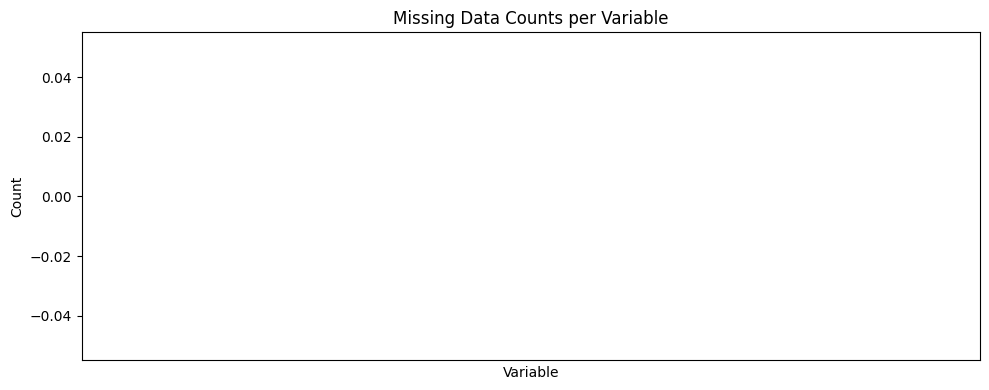

In [13]:
eda_helper_functions.plot_missing_info(train)

## 5. High Level Analysis of outlier

### Isolation Forest

>- So It is Ensemble learning algorithm were used for detecting the outliers.
>- As we have multiple sub Decision tress.
>- So first it selects random Numeric feature and select random value and perform split over it.
>- After splitting on that it will isolate the anomaly immediately because they are different from the majority of the data.
>- Further it will perform over each subtree and defines a tree.
>- Finally it takes an average of all trees at which depth like level 1 or 2 or 3 outliers are captured that will be the score.
>- Based on that score it will return -1 or 1.
>- -1 is an outlier and 1 is not an outlier.

In [17]:
from sklearn.ensemble import IsolationForest

In [18]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [21]:
(
    train
    .assign(outlier=forest.fit_predict(train
                            .drop(columns='price')
                            .select_dtypes(include='number')
                          ))
    .query('outlier == -1')
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
2,Jet Airways,2019-05-12,Kolkata,Banglore,2024-06-22 17:00:00,2024-06-22 22:05:00,1745,1.0,No Info,13067,-1
3,Air India,2019-05-09,Delhi,Cochin,2024-06-22 14:25:00,2024-06-22 19:15:00,1730,2.0,No Info,13591,-1
4,Air India,2019-03-06,Mumbai,Hyderabad,2024-06-22 12:45:00,2024-06-22 19:25:00,1840,2.0,No Info,13253,-1
5,Air India,2019-03-01,Delhi,Cochin,2024-06-22 09:45:00,2024-06-22 08:15:00,1350,1.0,No Info,22798,-1
7,Jet Airways,2019-05-15,Kolkata,Banglore,2024-06-22 16:30:00,2024-06-22 12:00:00,1170,1.0,In-flight meal not included,10844,-1
...,...,...,...,...,...,...,...,...,...,...,...
617,Air India,2019-06-12,Delhi,Cochin,2024-06-22 09:45:00,2024-06-22 08:15:00,1350,1.0,No Info,8991,-1
619,Jet Airways,2019-06-24,Delhi,Cochin,2024-06-22 20:55:00,2024-06-22 19:00:00,1325,1.0,In-flight meal not included,10262,-1
620,Air India,2019-06-09,Kolkata,Banglore,2024-06-22 09:10:00,2024-06-22 13:15:00,245,1.0,No Info,8996,-1
630,Air India,2019-05-01,Kolkata,Banglore,2024-06-22 09:25:00,2024-06-22 18:20:00,535,2.0,No Info,8366,-1


## 6. Pair Plots

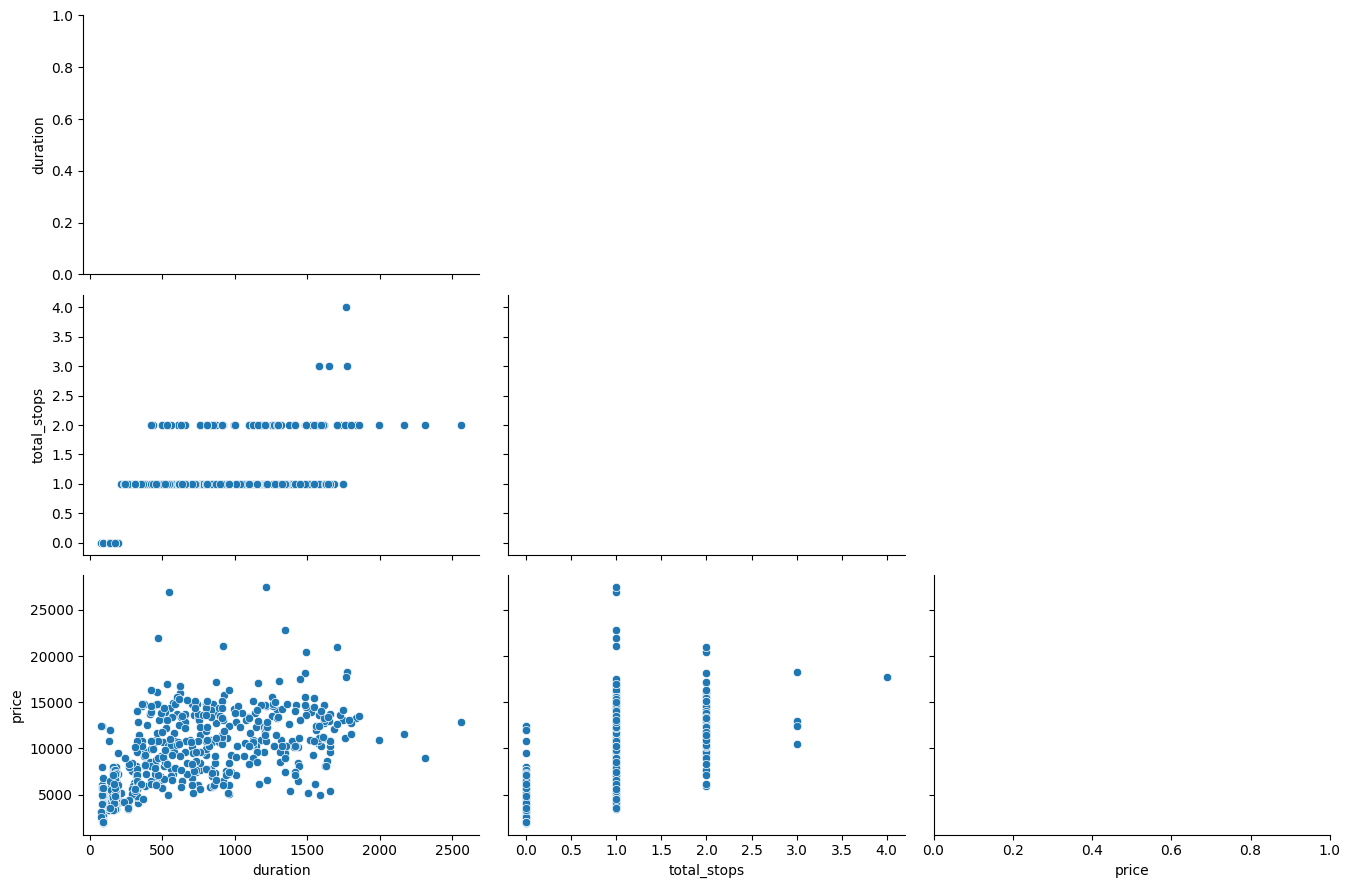

In [23]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

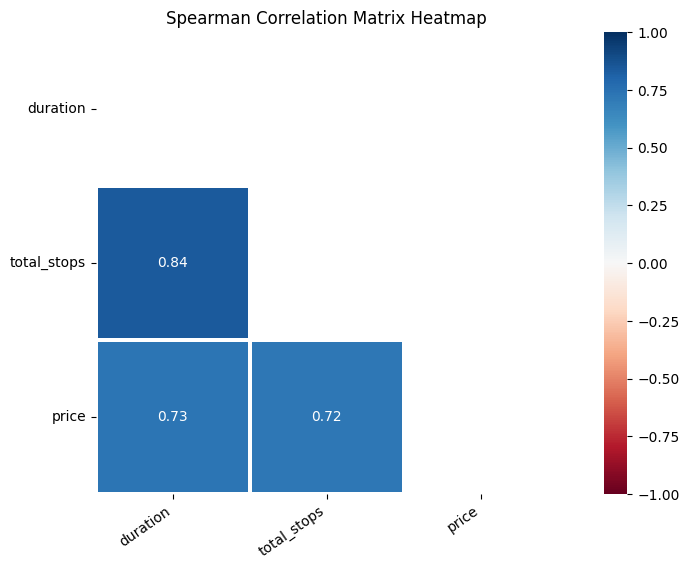

In [25]:
eda_helper_functions.correlation_heatmap(train)

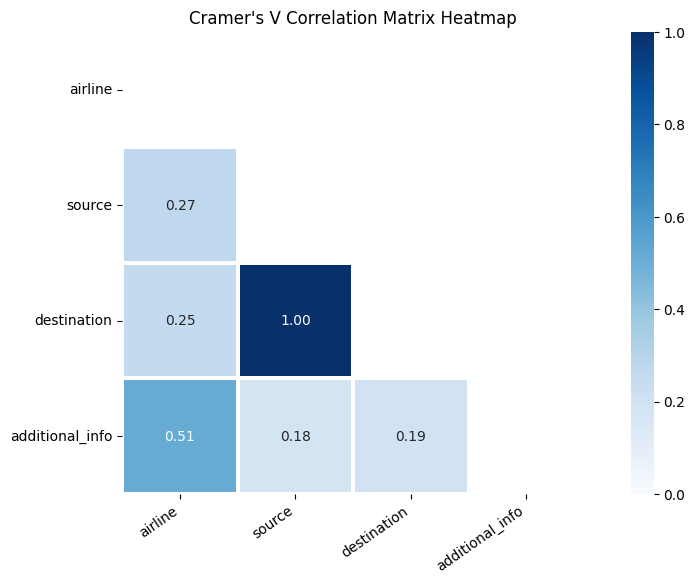

In [30]:
eda_helper_functions.cramersV_heatmap(train.assign(
                                        
))